## Project Overview

**This project aims to predict the Remaining Useful Life (RUL) of turbofan engines using sequence models (LSTM/GRU) trained on NASA CMAPSS sensor data.**

## Dataset Composition (FD001)
URL: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

**Train file: train_FD001.xlsx — time series per engine unit until failure.<br>
Test file: test_FD001.xlsx — truncated time series per engine unit (not run to failure).<br>
RUL file: RUL_FD001.txt — per-unit offsets giving remaining cycles at the last test timestamp.<br>**

**Key columns: unit number (engine ID), time (cycle index), and multiple sensor columns.<br>
Target definition (train): RUL = max(time) per unit – time.<br>
Target definition (test): RUL = (last_time per unit + RUL_offset from file) – time.<br>
Evaluation metrics: MAE, RMSE, and R²; main report uses last window per unit to mirror deployment.<br>**

### 1. Imports & Global Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.linear_model import LinearRegression

# Settings
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Data Loading & Feature Selection

- Load Excel
- Compute train RUL per unit: max(time) − time
- Drop constant columns (noise removal)
- Pick features by excluding unit number, time, RUL (+ any extras)

In [ ]:
def load_and_prepare(file_path: str) -> pd.DataFrame:
    df = pd.read_excel(file_path, header=0)
    df["time"] = pd.to_numeric(df["time"], errors="coerce")

    # Calculate RUL per unit (max(time) - time)
    max_cycles = (
        df.groupby("unit number")["time"].max().rename("max_cycle").reset_index()
    )
    df = df.merge(max_cycles, on="unit number", how="left")
    df["RUL"] = df["max_cycle"] - df["time"]
    df.drop(columns=["max_cycle"], inplace=True)

    # Drop constant-value columns
    single_val_cols = [c for c in df.columns if df[c].nunique() == 1]
    if single_val_cols:
        print("[INFO] Dropping constant columns:", single_val_cols)
        df = df.drop(columns=single_val_cols)

    # Summary output 
    print("Train shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print(df.head())
    print("RUL min/max:", float(df["RUL"].min()), float(df["RUL"].max()))
    return df

def pick_feature_columns(df: pd.DataFrame, extra_excludes=None) -> list[str]:
    base_excludes = {"unit number", "time", "RUL"}
    if extra_excludes:
        base_excludes |= set(extra_excludes)
    base_excludes = [c for c in base_excludes if c in df.columns]
    feature_cols = [c for c in df.columns if c not in base_excludes]
    print("Features:", feature_cols)
    return feature_cols

# ---- Run ----
file_path = r"\train_FD001.xlsx"
df = load_and_prepare(file_path)
feature_cols = pick_feature_columns(df)


[INFO] Dropping constant columns: ['operational setting 2', 'operational setting 3', 'sensor 4', 'sensor 9', 'sensor 15', 'sensor 17', 'sensor 18']
Train shape: (20631, 20)
Columns: ['unit number', 'time', 'time in cycles', 'operational setting 1', 'sensor 1', 'sensor 2', 'sensor 3', 'sensor 5', 'sensor 6', 'sensor 7', 'sensor 8', 'sensor 10', 'sensor 11', 'sensor 12', 'sensor 13', 'sensor 14', 'sensor 16', 'sensor 19', 'sensor 20', 'RUL']
   unit number  time  time in cycles  operational setting 1  sensor 1  \
0            1     1         -0.0007                -0.0004    641.82   
1            1     2          0.0019                -0.0003    642.15   
2            1     3         -0.0043                 0.0003    642.35   
3            1     4          0.0007                 0.0000    642.35   
4            1     5         -0.0019                -0.0002    642.37   

   sensor 2  sensor 3  sensor 5  sensor 6  sensor 7  sensor 8  sensor 10  \
0   1589.70   1400.60     21.61    554.36

### 2. Exploratory Data Analysis (EDA)

- Histograms: Visualize feature distributions (exclude IDs, time, etc.).
- Correlation Heatmap: Inspect linear relationships among features.
- Filtered Correlation: Highlight moderately high correlations (0.7 ≤ |corr| ≤ 0.9) to detect redundancy.

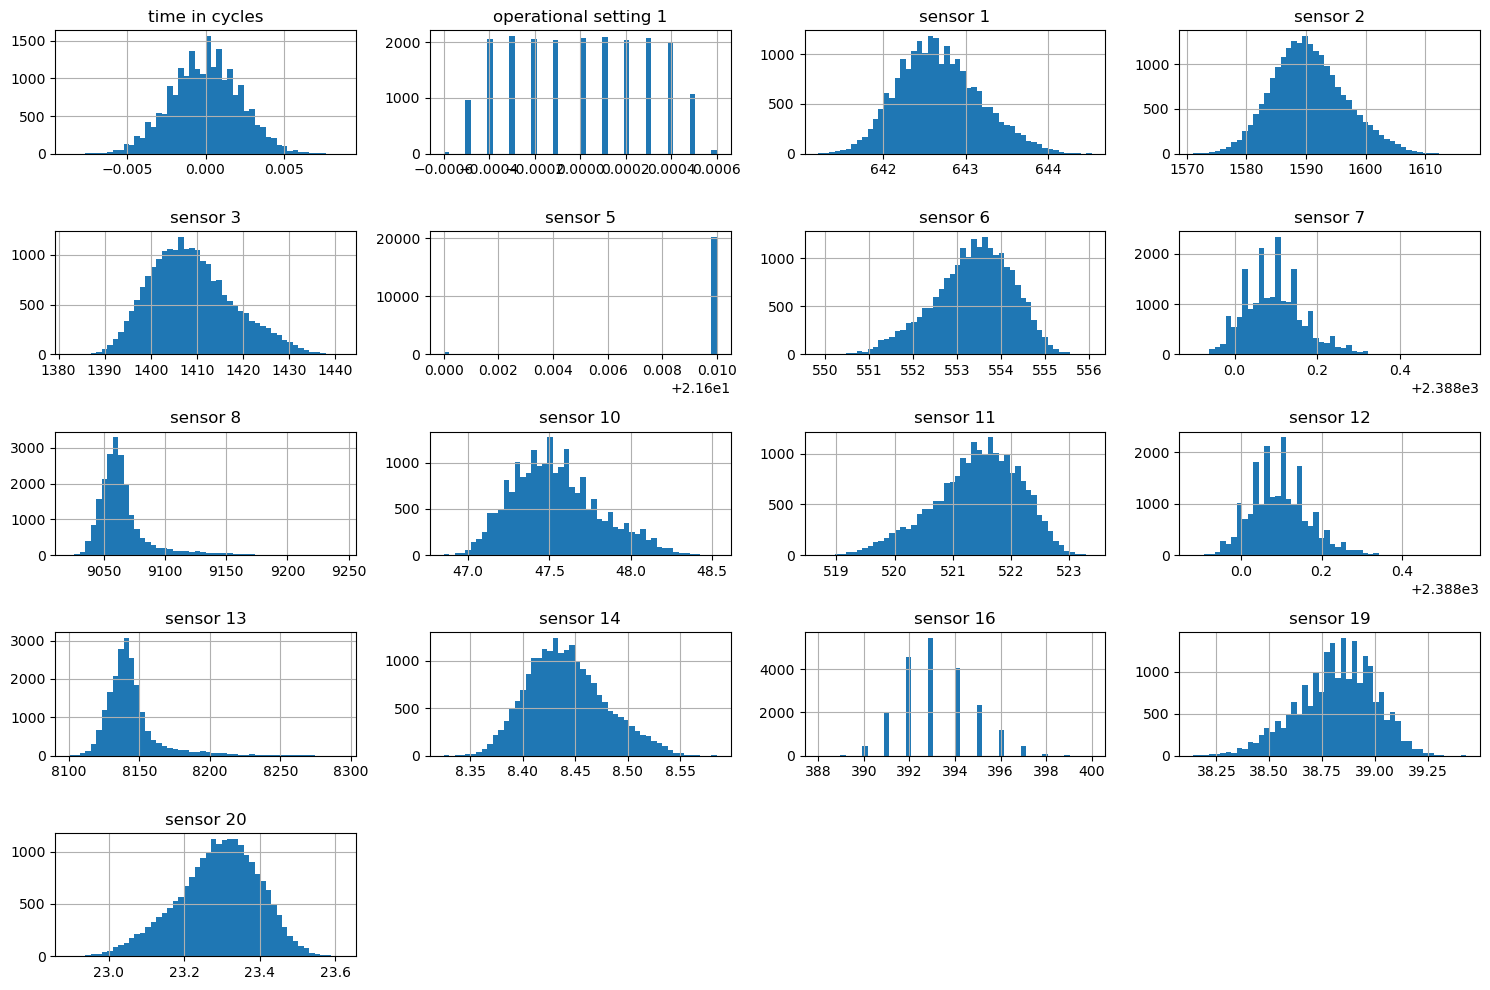

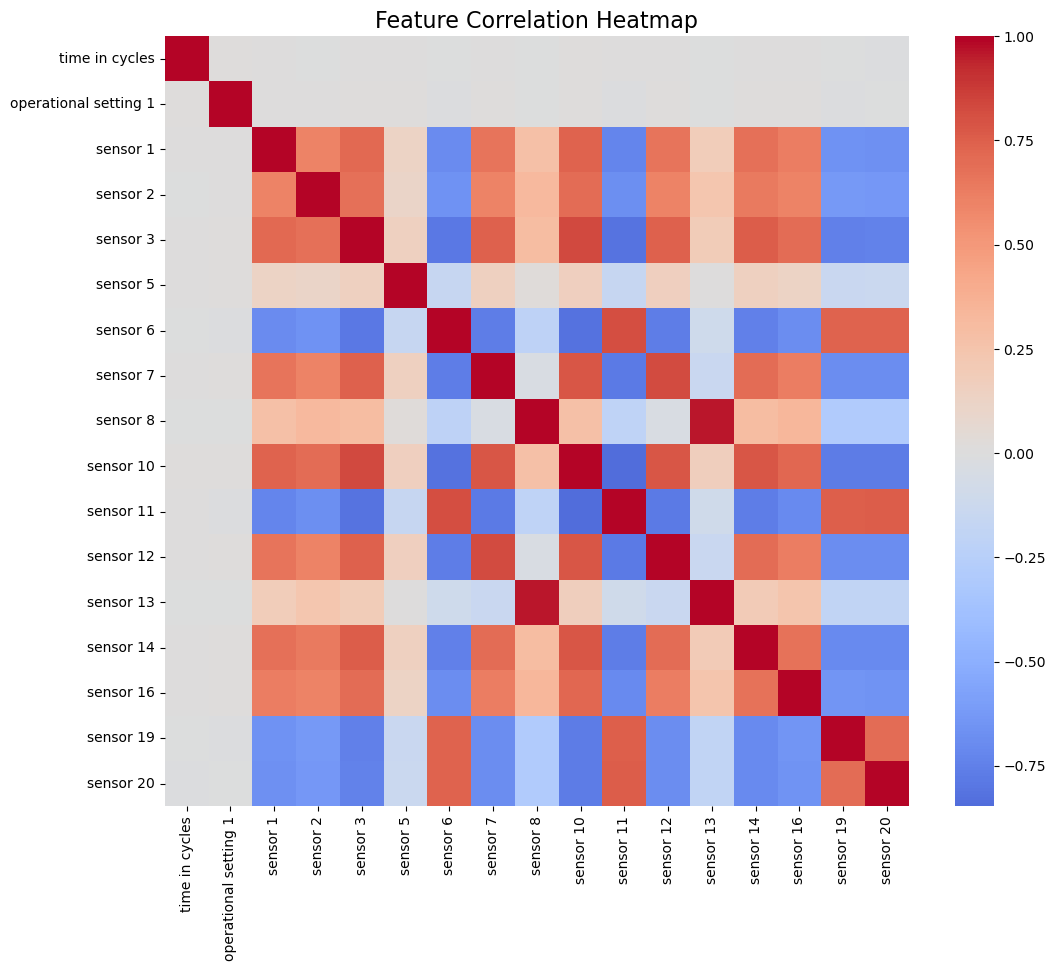

▶ 높은 상관 (0.7 ≤ |corr| ≤ 0.9)
           sensor 1  sensor 3  sensor 6  sensor 7  sensor 10  sensor 11  \
sensor 1        NaN  0.714949 -0.702136       NaN   0.740020  -0.724578   
sensor 3   0.714949       NaN -0.793130  0.746852   0.830136  -0.815591   
sensor 6  -0.702136 -0.793130       NaN -0.767132  -0.822805   0.812713   
sensor 7        NaN  0.746852 -0.767132       NaN   0.782213  -0.786540   
sensor 10  0.740020  0.830136 -0.822805  0.782213        NaN  -0.846884   
sensor 11 -0.724578 -0.815591  0.812713 -0.786540  -0.846884        NaN   
sensor 12       NaN  0.745158 -0.764611  0.826084   0.780761  -0.788441   
sensor 14       NaN  0.758459 -0.747051  0.700949   0.780913  -0.766052   
sensor 16       NaN  0.703499       NaN       NaN   0.722296  -0.703485   
sensor 19       NaN -0.748067  0.736163       NaN  -0.771510   0.751943   
sensor 20       NaN -0.745193  0.737447       NaN  -0.772554   0.756263   

           sensor 12  sensor 14  sensor 16  sensor 19  sensor 20  
sen

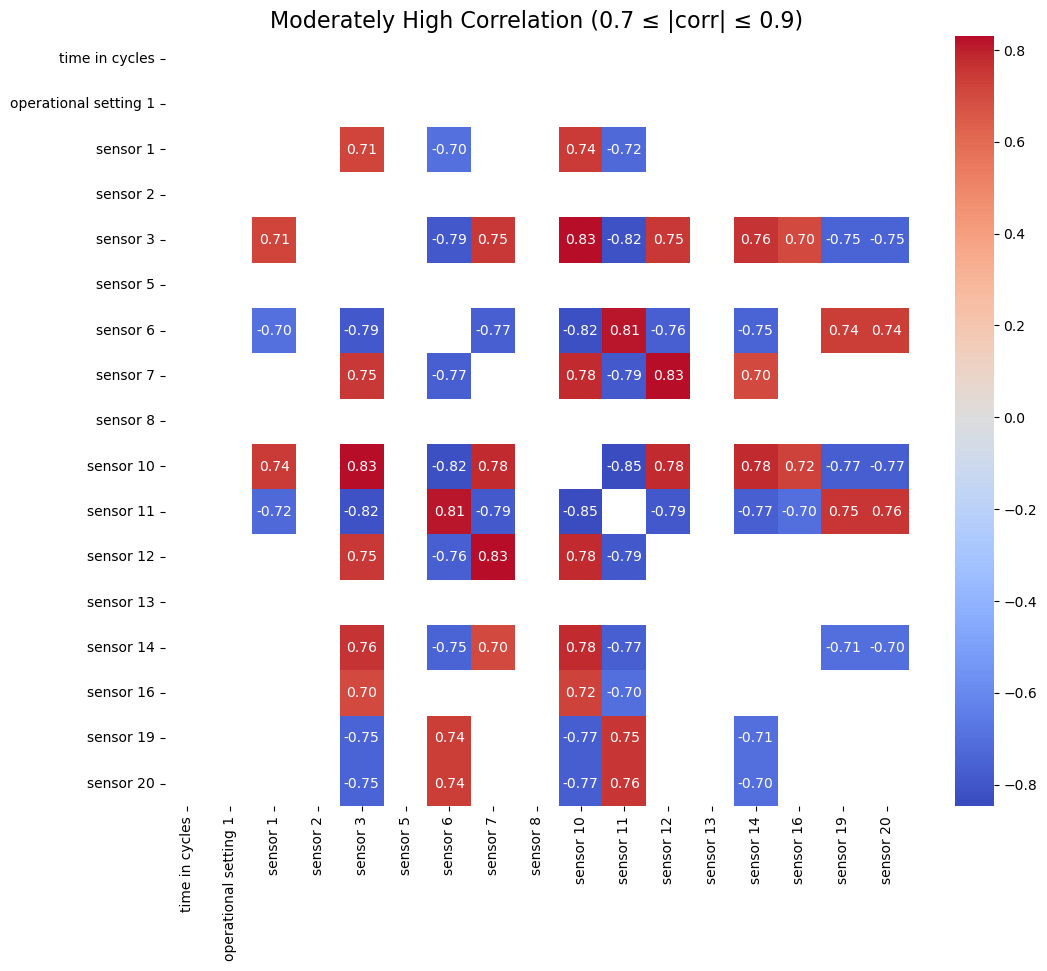

In [3]:
def plot_histograms(df: pd.DataFrame, exclude_cols: list[str]) -> None:
    hist_cols = [c for c in df.columns if c not in exclude_cols]
    if not hist_cols:
        print("[WARN] no columns to plot.")
        return
    df[hist_cols].hist(bins=50, figsize=(15, 10))
    plt.tight_layout()
    plt.show()


def plot_correlations(df: pd.DataFrame, feature_cols: list[str]) -> None:
    corr = df[feature_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title("Feature Correlation Heatmap", fontsize=16)
    plt.show()


def plot_filtered_correlations(df: pd.DataFrame, feature_cols: list[str],
                               low: float = 0.7, high: float = 0.9) -> None:
    corr = df[feature_cols].corr()
    mask = (np.abs(corr) >= low) & (np.abs(corr) <= high) & (corr != 1.0)
    filtered = corr.where(mask)
    print(f"▶ 높은 상관 ({low} ≤ |corr| ≤ {high})")
    print(filtered.dropna(how="all").dropna(axis=1, how="all"))
    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(f"Moderately High Correlation ({low} ≤ |corr| ≤ {high})", fontsize=16)
    plt.show()
    
# ---- Run ----
exclude_cols = ["unit number", "time", "RUL"]
plot_histograms(df, exclude_cols=exclude_cols)
plot_correlations(df, feature_cols)
plot_filtered_correlations(df, feature_cols, low=0.7, high=0.9)

### 3) Sequences & Scaling

- Unit-wise split: split by unit number, fit StandardScaler on train only, then transform val.
- Sliding windows: build (seq_len, features) windows; target is the last timestep RUL.

In [4]:
def make_sequences(frame: pd.DataFrame, seq_len: int,
                   feature_cols: list[str], target_col: str = "RUL"):
    X_list, Y_list = [], []
    skipped = 0
    for _, g in frame.groupby("unit number"):
        g = g.sort_values("time")
        if len(g) < seq_len:
            skipped += 1
            continue
        Xg = g[feature_cols].values
        Yg = g[target_col].values
        for i in range(len(g) - seq_len + 1):
            X_list.append(Xg[i:i+seq_len])
            Y_list.append(Yg[i + seq_len - 1])  # last timestep target

    if skipped:
        print(f"[INFO] Skipped units (<{seq_len} cycles): {skipped}")

    X = np.array(X_list, dtype=np.float32)
    y = np.array(Y_list, dtype=np.float32)
    return X, y

def split_scale_to_sequences(df: pd.DataFrame, feature_cols: list[str],
                             seq_len: int = 30, val_size: float = 0.2, seed: int = 42):
    units = df["unit number"].unique()
    train_units, val_units = train_test_split(
        units, test_size=val_size, random_state=seed, shuffle=True
    )

    train_df = df[df["unit number"].isin(train_units)].reset_index(drop=True)
    val_df   = df[df["unit number"].isin(val_units)].reset_index(drop=True)

    scaler = StandardScaler().fit(train_df[feature_cols].values)

    train_scaled = train_df.copy()
    val_scaled   = val_df.copy()
    train_scaled[feature_cols] = scaler.transform(train_df[feature_cols].values)
    val_scaled[feature_cols]   = scaler.transform(val_df[feature_cols].values)

    X_train, y_train = make_sequences(train_scaled, seq_len, feature_cols, "RUL")
    X_val,   y_val   = make_sequences(val_scaled,   seq_len, feature_cols, "RUL")

    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
    return X_train, y_train, X_val, y_val, scaler

# ---- Run ----
X_train, y_train, X_val, y_val, scaler = split_scale_to_sequences(df, feature_cols, seq_len=30)

X_train: (14241, 30, 17) y_train: (14241,)
X_val:   (3490, 30, 17) y_val:   (3490,)


### 4) Model & Train/Eval
- Training/validation used **all windows** instead of only the final one,<br>in order to increase the number of training samples and let the model learn degradation patterns across the whole life cycle. 
- Architecture: Stacked LSTM/GRU → Dropout → Dense(1) for RUL regression.  
- Training control: ReduceLROnPlateau + EarlyStopping(restore_best_weights=True).    
- **Output**: 
    - LSTM: MAE = 16.428, RMSE = 24.454, R² = 0.824  
    - GRU: MAE = 16.904, RMSE = 24.453, R² = 0.824  


In [6]:
def build_lstm(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # RUL regression
    ])
    opt = tf.keras.optimizers.Adam(1e-3)  
    model.compile(optimizer=opt,
                  loss="mae",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return model

def build_gru(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(128, return_sequences=True),
        layers.Dropout(0.2),
        layers.GRU(64),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=opt,
                  loss="mae",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return model

def make_callbacks():
    return [
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
        callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ]

def train_and_eval(model, X_train, y_train, X_val, y_val,
                   epochs=80, batch_size=256, tag="MODEL"):
    """Fit the model and report MAE/RMSE/R2 on validation set."""
    cbs = make_callbacks()
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        shuffle=True,
        callbacks=cbs, verbose=1
    )
    pred_val = model.predict(X_val, verbose=0).ravel()
    mae  = mean_absolute_error(y_val, pred_val)
    rmse = mean_squared_error(y_val, pred_val, squared=False)
    r2   = r2_score(y_val, pred_val)
    print(f"[{tag}] VAL MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    return history, {"MAE": mae, "RMSE": rmse, "R2": r2}

# ---- Run ----
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, num_features)

# Run LSTM
lstm_model = build_lstm(input_shape)
hist_lstm, metrics_lstm = train_and_eval(
    lstm_model, X_train, y_train, X_val, y_val,
    epochs=80, batch_size=256, tag="LSTM"
)

# Run GRU
gru_model = build_gru(input_shape)
hist_gru, metrics_gru = train_and_eval(
    gru_model, X_train, y_train, X_val, y_val,
    epochs=80, batch_size=256, tag="GRU"
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,385 (501.50 KB)

 Trainable params: 128,385 (501.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 90.0621 - rmse: 109.7123 - val_loss: 64.4951 - val_rmse: 82.6777 - learning_rate: 0.0010
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 58.7990 - rmse: 79.5299 - val_loss: 31.9103 - val_rmse: 47.0518 - learning_rate: 0.0010
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 31.2018 - rmse: 48.4042 - val_loss: 19.0390 - val_rmse: 29.4287 - learning_rate: 0.0010
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 23.3678 - rmse: 37.2414 - val_loss: 17.4698 - val_rmse: 25.7475 - learning_rate: 0.0010
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - loss: 21.6473 - rmse: 34.3638 - val_loss: 17.0306 - val_rmse: 24.7988 - learning_rate: 0.0010
Epoch 6/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 20.8812 - rmse: 33.2907 - val_loss: 16.4282 - val_rmse: 24.4539 - learning_rate: 0.0010
Epoch 7/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 20.2374 - rmse: 32.4272 - val_loss: 16.5468 

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 30, 128)             │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,921 (382.50 KB)

 Trainable params: 97,921 (382.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 91.9379 - rmse: 111.3754 - val_loss: 78.8050 - val_rmse: 97.1731 - learning_rate: 0.0010
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 78.7892 - rmse: 99.5401 - val_loss: 64.7610 - val_rmse: 83.2292 - learning_rate: 0.0010
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 63.4222 - rmse: 84.4772 - val_loss: 46.7101 - val_rmse: 64.4431 - learning_rate: 0.0010
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 46.8259 - rmse: 66.1681 - val_loss: 34.7371 - val_rmse: 49.0517 - learning_rate: 0.0010
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 37.4932 - rmse: 53.7543 - val_loss: 31.2967 - val_rmse: 43.2074 - learning_rate: 0.0010
Epoch 6/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 35.8953 - rmse: 50.4051 - val_loss: 30.6903 - val_rmse: 42.4300 - learning_rate: 0.0010
Epoch 7/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 35.2961 - rmse: 49.6151 - val_loss: 27.5087 - v

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 5) External Evaluation
- Evaluation used **final window only** per unit, following the NASA test protocol,<br>
since the practical scenario is to estimate the remaining useful life at the last observed cycle.  
- Preprocessing: Applies the same feature_cols, scaler, and seq_len as training (no leakage).  
- **Output**: LSTM outperforms GRU on the external test.  
  - LSTM: MAE = 12.556, RMSE = 18.553, R² = 0.801
  - GRU: MAE = 13.873, RMSE = 19.681, R² = 0.776

In [ ]:
def evaluate_on_external_test_last_only(model,
                                        test_path: str,
                                        rul_path: str,
                                        scaler,
                                        feature_cols: list[str],
                                        seq_len: int,
                                        target_cap: int | None = None,
                                        target_transform=None,
                                        inverse_target_transform=None,
                                        verbose: bool = False):
    """
    Evaluate ONLY the last window per unit (NASA-style).
    Uses the SAME feature_cols, scaler, and seq_len as training.
    """
    # 1) Load
    test_df = pd.read_excel(test_path, header=0)
    test_df["time"] = pd.to_numeric(test_df["time"], errors="coerce")

    # 2) NASA-style RUL reconstruction with offsets (RUL_FD001.txt)
    rul_df = pd.read_csv(rul_path, header=None, names=["RUL_offset"])
    units_in_test = np.sort(test_df["unit number"].unique())
    assert len(units_in_test) == len(rul_df), \
        f"Unit count mismatch: test={len(units_in_test)}, rul={len(rul_df)}"

    unit_rul_map = pd.DataFrame({
        "unit number": units_in_test,
        "RUL_offset": rul_df["RUL_offset"].values
    })
    last_time = test_df.groupby("unit number")["time"].max().rename("last_time").reset_index()
    max_cycle_adj = last_time.merge(unit_rul_map, on="unit number", how="left")
    max_cycle_adj["max_cycle_adj"] = max_cycle_adj["last_time"] + max_cycle_adj["RUL_offset"]
    test_df = test_df.merge(max_cycle_adj[["unit number", "max_cycle_adj"]],
                            on="unit number", how="left")
    test_df["RUL"] = test_df["max_cycle_adj"] - test_df["time"]

    if target_cap is not None:
        test_df["RUL"] = np.minimum(test_df["RUL"], target_cap)

    # 3) Scale with TRAIN-FITTED scaler
    test_df_scaled = test_df.copy()
    test_df_scaled[feature_cols] = scaler.transform(test_df[feature_cols].values)

    # 4) Predict 
    last_preds, last_trues, used_units = [], [], []
    for uid, g in test_df_scaled.groupby("unit number"):
        g = g.sort_values("time")
        if len(g) < seq_len:
            continue
        Xg = g[feature_cols].values
        Yg = g["RUL"].values
        X_last = Xg[-seq_len:]                  # (seq_len, feat)
        y_last = Yg[-1]                         # target at last timestep
        p = model.predict(X_last[None, ...], verbose=0).ravel()[0]

        if inverse_target_transform is not None:
            p = inverse_target_transform(np.array([p]))[0]

        last_preds.append(p)
        last_trues.append(y_last)
        used_units.append(uid)

    last_trues = np.array(last_trues, dtype=np.float32)
    last_preds = np.array(last_preds, dtype=np.float32)

    # 5) Metrics
    mae  = mean_absolute_error(last_trues, last_preds)
    rmse = mean_squared_error(last_trues, last_preds, squared=False)
    r2   = r2_score(last_trues, last_preds)
    if verbose:
        print(f"[EXTERNAL TEST - last window per unit] MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}, (last_trues, last_preds), used_units

# ---- Evaluate both models ----
test_path = r"\test_FD001.xlsx"
rul_path  = r"\RUL_FD001.txt"

metrics_last_lstm, (y_last_lstm, p_last_lstm), used_units = evaluate_on_external_test_last_only(
    model=lstm_model,
    test_path=test_path,
    rul_path=rul_path,
    scaler=scaler,
    feature_cols=feature_cols,
    seq_len=30,
    target_cap=None,
    target_transform=None,
    inverse_target_transform=None,
    verbose=False 
)

metrics_last_gru, (y_last_gru, p_last_gru), _ = evaluate_on_external_test_last_only(
    model=gru_model,
    test_path=test_path,
    rul_path=rul_path,
    scaler=scaler,
    feature_cols=feature_cols,
    seq_len=30,
    target_cap=None,
    target_transform=None,
    inverse_target_transform=None,
    verbose=False  
)

def format_metrics(m):
    return f"{{'MAE': {m['MAE']:.3f}, 'RMSE': {m['RMSE']:.3f}, 'R2': {m['R2']:.3f}}}"

# ---- Run ----
print("\n===== External Test (Last Window Only) Comparison =====")
print("LSTM:", format_metrics(metrics_last_lstm))
print("GRU :", format_metrics(metrics_last_gru))


C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



===== External Test (Last Window Only) Comparison =====
LSTM: {'MAE': 12.556, 'RMSE': 18.553, 'R2': 0.801}
GRU : {'MAE': 13.873, 'RMSE': 19.681, 'R2': 0.776}


C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 6) Visualization — Parity Plots

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


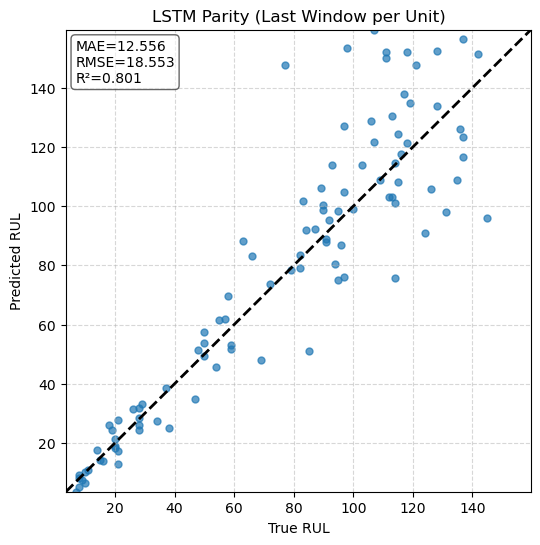

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


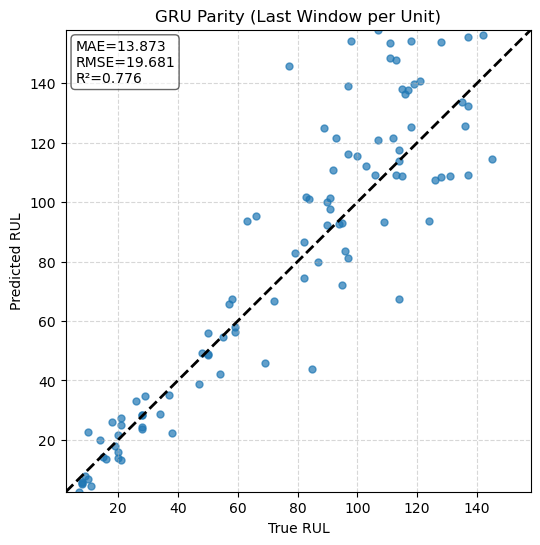

In [8]:
def plot_parity(y_true, y_pred, title: str):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)

    lim_min = float(min(y_true.min(), y_pred.min()))
    lim_max = float(max(y_true.max(), y_pred.max()))

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=25, alpha=0.7)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], "k--", lw=2)
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(title)
    plt.xlim(lim_min, lim_max)
    plt.ylim(lim_min, lim_max)
    plt.grid(True, linestyle="--", alpha=0.5)
    txt = f"MAE={mae:.3f}\nRMSE={rmse:.3f}\nR²={r2:.3f}"
    plt.gca().text(0.02, 0.98, txt, transform=plt.gca().transAxes,
                   va="top", ha="left",
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))
    plt.show()

# ---- Plot LSTM vs GRU parity ----
plot_parity(y_last_lstm, p_last_lstm, title="LSTM Parity (Last Window per Unit)")
plot_parity(y_last_gru,  p_last_gru,  title="GRU Parity (Last Window per Unit)")
